In [21]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage import morphology
from skimage.morphology import reconstruction
from skimage import measure


In [22]:
img_bgr = cv2.imread("../image.jpg", cv2.IMREAD_GRAYSCALE)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
img = cv2.resize(img_rgb, (512, 512), interpolation=cv2.INTER_AREA)

selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))

In [23]:
# Top-hat et Bottom-hat
opened = cv2.morphologyEx(img, cv2.MORPH_OPEN, selem)
closed = cv2.morphologyEx(img, cv2.MORPH_CLOSE, selem)

tophat = cv2.subtract(img, opened)
bothat = cv2.subtract(closed, img)

# Rehaussement du contraste global
enhanced = cv2.add(img, tophat)
enhanced = cv2.subtract(enhanced, bothat)

# Normalisation
enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


small_selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

# Opening = suppression du bruit clair isolé
opened = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, small_selem)

# Closing = comblement de petits trous dans les vaisseaux
cleaned = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, small_selem)

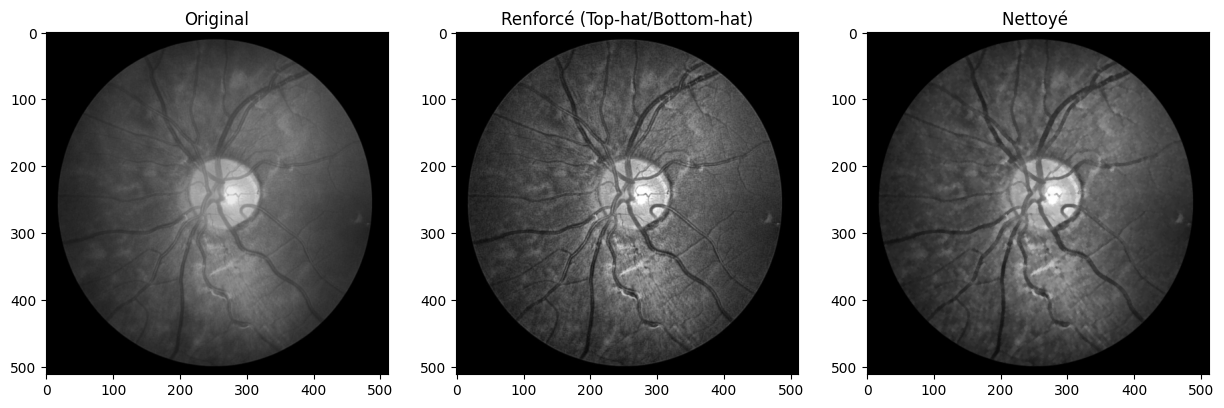

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1); plt.imshow(img, cmap='gray'); plt.title('Original')
plt.subplot(1,3,2); plt.imshow(enhanced, cmap='gray'); plt.title('Renforcé (Top-hat/Bottom-hat)')
plt.subplot(1,3,3); plt.imshow(cleaned, cmap='gray'); plt.title('Nettoyé ')
plt.show()

In [25]:
# Geodesic reconstruction (preserve vessel structure)

gray = cv2.cvtColor(cleaned, cv2.COLOR_RGB2GRAY)
marker = cv2.cvtColor(opened, cv2.COLOR_RGB2GRAY)
mask = gray
reconstructed = reconstruction(marker, mask, method='dilation')

In [26]:
img = cv2.imread(str("../image.jpg"))
green = img[:, :, 1]

In [27]:

# CLAHE: local contrast enhancement
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced = clahe.apply(green)

def multi_scale_opening(img, radii=[3, 5, 7]):
    """Paper: 'smoothing operation using mathematical morphology'"""
    result = np.zeros_like(img)
    for r in radii:
        se = morphology.disk(r)
        opened = morphology.opening(img, se)
        result = np.maximum(result, opened)
    return result

smooth = multi_scale_opening(enhanced)


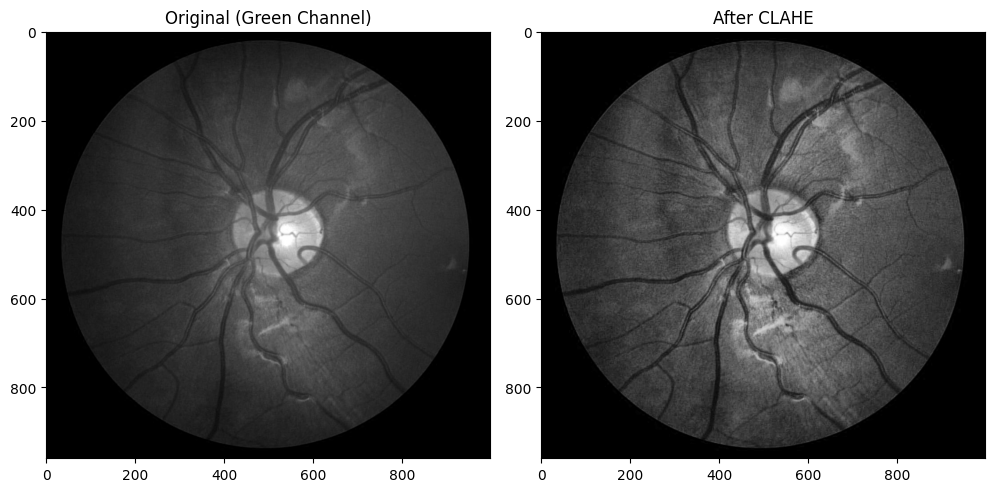

In [28]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(green, cmap='gray')
plt.title("Original (Green Channel)")

plt.subplot(1, 3, 2)
plt.imshow(enhanced, cmap='gray')
plt.title("After CLAHE")

plt.tight_layout()
plt.show()

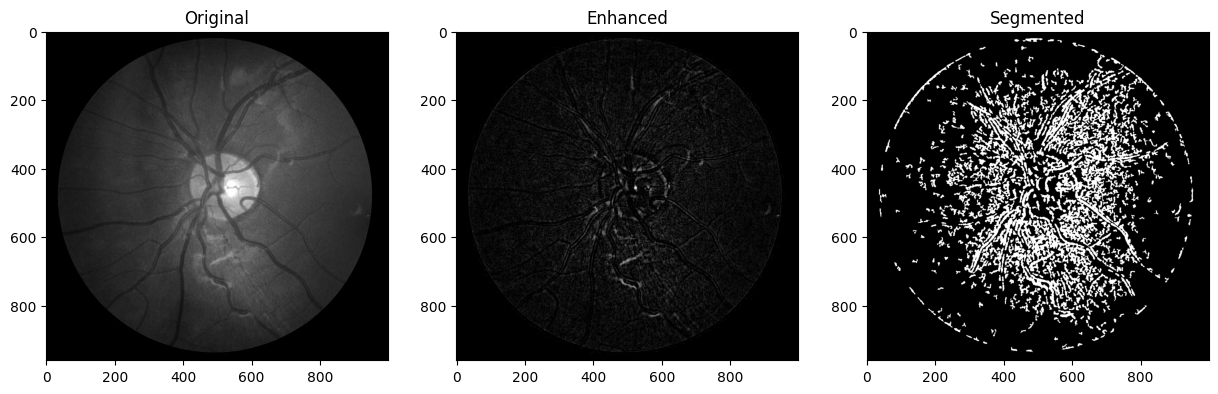

In [29]:

from scipy.ndimage import gaussian_filter


def kmeans_segmentation(img, n_clusters=2):
    """
    K-means clustering segmentation (Section 4.2 of paper)
    
    Args:
        img: Input grayscale image
        n_clusters: Number of clusters (2 for binary: vessel/background)
    
    Returns:
        Binary segmentation mask
    """
    
    # Reshape image to feature vector
    h, w = img.shape
    img_flat = img.reshape(-1, 1).astype(np.float32)
    
    # K-means clustering
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)
    _, labels, centers = cv2.kmeans(
        img_flat, 
        n_clusters, 
        None, 
        criteria, 
        10,  # attempts
        cv2.KMEANS_PP_CENTERS
    )
    # Reshape labels back to image
    labels = labels.reshape(h, w)
    
    # Determine which cluster is vessels (brighter in enhanced image)
    if centers[0] > centers[1]:
        vessel_label = 0
    else:
        vessel_label = 1
    
    # Create binary mask
    binary = (labels == vessel_label).astype(np.uint8)
    
    return binary

def simplified_morphology_kmeans(image_path):
    """
    Simplified version if the full method is too slow
    Uses same principles but fewer directions
    """
    
    
    green = img[:, :, 1]
    
    # 1. Background subtraction using large opening
    bg_se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    background = cv2.morphologyEx(green, cv2.MORPH_OPEN, bg_se)
    enhanced = cv2.subtract(green, background)
    
    # 2. Multi-scale opening (similar to paper but faster)
    smoothed = np.zeros_like(enhanced, dtype=float)
    for size in [3, 5, 7]:
        se = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
        opened = cv2.morphologyEx(enhanced, cv2.MORPH_OPEN, se)
        smoothed = np.maximum(smoothed, opened)
    
    # 3. Top-hat to enhance vessels
    se_tophat = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    tophat = cv2.morphologyEx(smoothed.astype(np.uint8), cv2.MORPH_TOPHAT, se_tophat)
    
    # 4. Gaussian smoothing
    gaussian = gaussian_filter(tophat, sigma=1.5)
    
    # 5. K-means
    binary = kmeans_segmentation(gaussian)
    
    # 6. Cleanup
    binary = morphology.remove_small_objects(binary.astype(bool), min_size=50)
    
    return {
        'original': green,
        'enhanced': enhanced,
        'binary': (binary * 255).astype(np.uint8)

    }




results = simplified_morphology_kmeans('image.jpg')
plt.figure(figsize=(15, 5))
plt.subplot(131); plt.imshow(results['original'], cmap='gray'); plt.title('Original')
plt.subplot(132); plt.imshow(results['enhanced'], cmap='gray'); plt.title('Enhanced')
plt.subplot(133); plt.imshow(results['binary'], cmap='gray'); plt.title('Segmented')
plt.show()

In [32]:
selem = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15,15))
opened = cv2.morphologyEx(smooth, cv2.MORPH_OPEN, selem)
closed = cv2.morphologyEx(smooth, cv2.MORPH_CLOSE, selem)

tophat = cv2.subtract(smooth, opened)
bothat = cv2.subtract(closed, smooth)

# Contrast enhancement
contrast = cv2.add(smooth, tophat)
contrast = cv2.subtract(contrast, bothat)
contrast = cv2.normalize(contrast, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

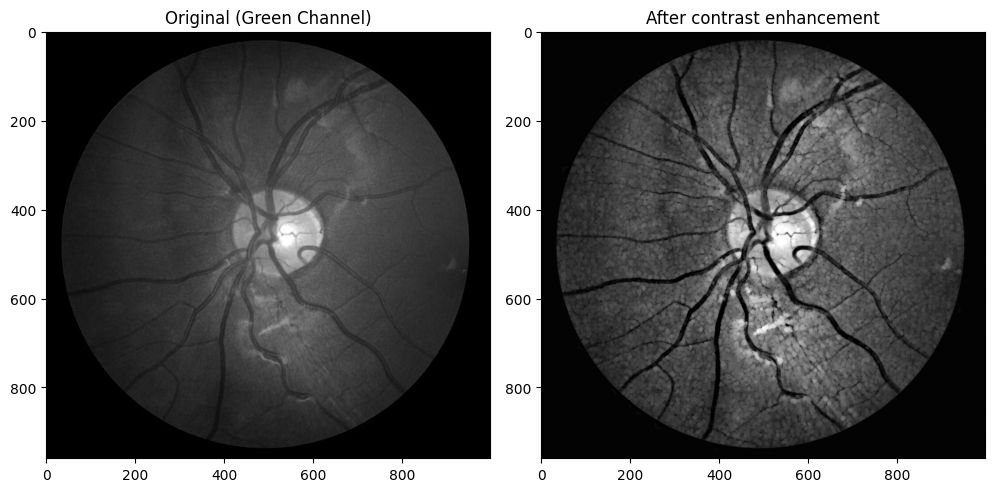

In [33]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(green, cmap='gray')
plt.title("Original (Green Channel)")

plt.subplot(1, 3, 2)
plt.imshow(contrast, cmap='gray')
plt.title("After contrast enhancement")

plt.tight_layout()
plt.show()

In [36]:


binary = (contrast).astype(np.uint8) * 255



small_se = morphology.disk(3)
binary = morphology.opening(binary, small_se)   # remove pepper
binary = morphology.closing(binary, morphology.disk(9))  # fill holes

# Remove tiny objects (< 60 px)
lbl = measure.label(binary)
for region in measure.regionprops(lbl):
    if region.area < 60:
        binary[lbl == region.label] = 0

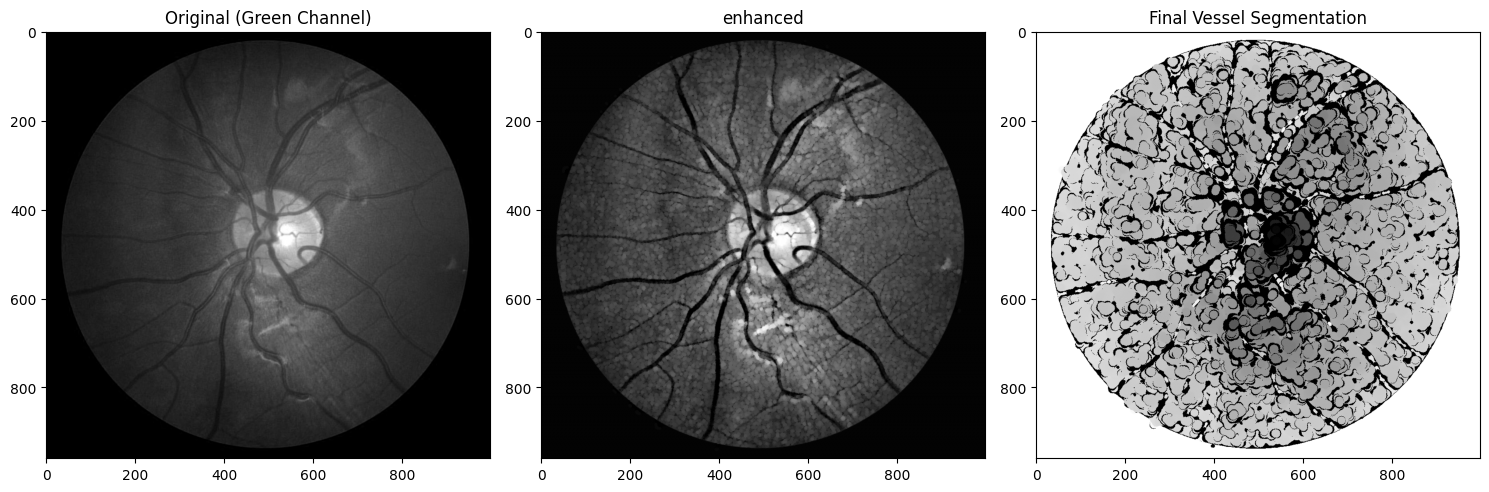

In [37]:
plt.figure(figsize=(15, 6))

plt.subplot(1, 3, 1)
plt.imshow(green, cmap='gray')
plt.title("Original (Green Channel)")

plt.subplot(1, 3, 2)
plt.imshow(contrast, cmap='gray')
plt.title("enhanced")

plt.subplot(1, 3, 3)
plt.imshow(binary, cmap='gray')
plt.title(f"Final Vessel Segmentation")

plt.tight_layout()
plt.show()